## Plot case studies

This notebook is to plot the weather maps for the case study discussed in the European heatwaves paper. This looks at ERA5 data and for a particularl heatwave (2019 and 2003) produces plots for the gph anomaly with hatching, corresponding SOM pattern, soil moisture/evaporative fraction, lists the blocked blocking indices and assigns the value of sinuosity for each day. 


In [1]:
### some useful Python packages to have at hand, some will not be needed
### in this notebbook
import numpy as np
import scipy
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import sys
import pandas as pd
import os
os.environ["PROJ_LIB"] = "/rds/general/user/kc1116/home/anaconda3/envs/zeus/share/proj"
import matplotlib as mpl
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import somoclu
import cartopy
import xarray
import xarray as xr
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap as bm
#import sklearn
from itertools import groupby
from scipy import stats
import cartopy.crs as ccrs
from statsmodels.stats.multitest import (multipletests, fdrcorrection,
                                         fdrcorrection_twostage,
                                         NullDistribution,
                                         local_fdr)
from scipy.stats import spearmanr, kendalltau, pearsonr #all produce identical results for binary test, use pearsonr for SOM pattern correlation
import glob
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
import matplotlib.lines as mlines

In [2]:
from functools import wraps
import errno
import os
import signal
#https://stackoverflow.com/questions/2281850/timeout-function-if-it-takes-too-long-to-finish
class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)

    return decorator

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
class MplColorHelper:
        def __init__(self, cmap_name, start_val, stop_val):
            self.cmap_name = cmap_name
            self.cmap = plt.get_cmap(cmap_name)
            self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
            self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

        def get_rgb(self, val):
            return self.scalarMap.to_rgba(val)

## Create a new colormap
This has the same gradation scaling as seismic, but can be made with different colours e.g. purple/green for soil moisture pattern.

In [4]:
COL = MplColorHelper('seismic', -330, 330)
bounds = np.arange(-330,360,30)
cols = COL.get_rgb(bounds)

In [5]:
green_cols = np.array(list(zip(cols[:,1],cols[:,0],cols[:,2],cols[:,3])))[12:]
purp_cols = np.array(list(zip(cols[:,0],cols[:,1],cols[:,0],cols[:,3])))[12:]

In [6]:
cols_cont_rearr = np.concatenate((np.flip(purp_cols, 0), green_cols), axis = 0)
newcmp = ListedColormap(cols_cont_rearr)

In [7]:
#First function takes the desired gph file, time-range, season and region and returns the prepared
#dataset for SOM_training
@timeout(5) #timeout prepData function after 5 seconds
def prepData(zg_file, yrst, yrend, season, lats_arr, lons_arr, g, zg_str):
    """
    Select the season and region from the data
    """
    #print("prepData")
    year_arr = np.arange(yrst,yrend+1)
    lats = zg_file['lat'] #good for 1x1 data
    lons = zg_file['lon']  #good for 1x1 data
    #print(f"data_europe_yr = {data_europe_yr}")    
    dates = zg_file['time']
    nt_yr, nr_lat, nr_lon = zg_file[zg_str].shape
    #print(f"data_europe_yr[zg_str].shape = {data_europe_yr[zg_str].shape}")  
    
    #data_yr_reshaped = data_europe_yr[zg_str].values.reshape(nt_yr, nr_lat*nr_lon)/g#*1e6#/g #reshaped for the SOM
    #print(f"data_yr_reshaped = {data_yr_reshaped}")     
    m = bm(projection='cyl',llcrnrlat=lats_arr[0],urcrnrlat=lats_arr[1]-1,llcrnrlon=lons_arr[0],urcrnrlon=lons_arr[1]-1,resolution='l') # may need to subtract 180 from the lon coords  
    return lats, lons, dates, nt_yr, nr_lat, nr_lon, m

In [8]:
#Function to plot the SOM trends
#added values to modify Gerald's function (issues with date formatting)
def plotSOMTrends(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str, mult_test_method, JJA_days=92, yrst=1979, yrend=2013, samp=10):
    """
    Plots the trends (occurrence, persistence, max duration) of the SOM patterns generated from the GPH data. 
    
    Parameters
    ----------
    som_yr    : somoclu.train.Somoclu
        The trained SOM (somoclu object)
    seas_yr   : xarray.DataArray
        Data array containing GPH data and information on time, latitude, longitude variables in the selected time range, season and region
        
    Returns
    ---------
    grad_list : list 
        List of the gradients of the pattern occurrence trends computed by linear least-squares regression 
    all_occur : list 
        List of occurrences per day in the trained dataset for each SOM pattern
    """
    
    #Extract pattern data (occurence, persistence, max duration)
    #Store each pattern data as a binary list of len(dates), i.e. [1,0,0,0,1...,1]
    bmus = som_yr.bmus
    global all_occur #Extra code to store the occurences in a global variable that I can access later

    all_occur = [[] for i in range(max(n_rows,n_columns))]
    for a in range(n_rows):
        for b in range(n_columns): 
            curr_occur = []
            for c in bmus:
                if c.tolist() == [b,a]: #### need to swap the indices here!! #b'a
                    curr_occur.append(1) #This pattern occured on this date
                else:
                    curr_occur.append(0) #This pattern didn't occur 
            all_occur[a].append(curr_occur)

    if n_columns == 1:
        f, axes1 = plt.subplots(nrows=n_rows, ncols=n_columns+1, figsize=(10,10))
    if n_rows == 1:
        f, axes1 = plt.subplots(nrows=n_rows+1, ncols=n_columns, figsize=(10,10))
    #Plotting axes the extracted circulation data 
    f, axes1 = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,10))
    f.subplots_adjust(hspace=0.2, wspace=0.2)


    #Now sort according to relevant dates
    #dates = seas_yrs['time'].data[:]
    #dates = pd.date_range(start='1/1/1979', end=f'31/12/{x}')

    #Loop through each set of circulation occurence data 
    

    test_num = 8 #number of p value tests in family of hypotheses (occ, persis, max_dur and event_no * 2)
    #pvalue and gradient matrices for each node
    pval_mat, grad_mat = np.zeros((n_rows,n_columns,test_num)), np.zeros((n_rows,n_columns,test_num))
    #Store trend values
    grad_list = []
    JJA_days = 100
    years_zeros = np.zeros((34*JJA_days))
    for row in range(n_rows):  
        for col in range(n_columns):
            #Need some exception handling for rare cases where any of the patterns doesnt occur in a year
            #NOTE the swapped indices [col][row] here! Doulbe check with Joy's code, see if node number can be confirmed
            #print(f"all_occur[row][col] = {all_occur[row][col]}")
            print(f"dates = {dates}")
            #all_occur[row][col] is the relevant matrix for investigating caase studies
            
            cum_data = pd.Series(np.array(all_occur[row][col]), index=dates.values)
            #to generate the years in the dataset, since cum_data.index.year has issues
            years_num = yrend - yrst
                        
            years_num = int(cum_data.shape[0]/JJA_days)
            years_zeros = np.zeros((years_num*JJA_days))
            arr_gen = np.array([years_zeros[JJA_days*i:JJA_days*(i+1)]+i+yrst for i in range(years_num)
                               ]).reshape(years_num*JJA_days)

            sort_to_year = cum_data.groupby(arr_gen).apply(list)
            year = sort_to_year.keys().tolist() #[1979, 1980,...]
            occ = [sum(d) for d in sort_to_year]  #[25,40,...]
            # Count streaks 
            streaks = [[sum(1 for i in g) for k,g in groupby(x) if k == 1] for x in sort_to_year]
            streak_count = [[(k, sum(1 for i in g)) for k,g in groupby(sorted(x)) ] for x in streaks]
            
            #Persistence (if statement to avoid division by zero )
            persis = [ sum([x[0]*x[1] for x in year])/sum([x[1] for x in year]) if sum([x[1] for x in year]) != 0 else 0 for year in streak_count ]
            #Max Duration 
            max_dur = [ year[-1][0] if year != [] else 0 for year in streak_count]
            

            def len_iter(items):
                return sum(1 for _ in items)            
            
            def consecutive_one_len(data):
                return len(list(len_iter(run) for val, run in groupby(data) if val))            
            event_no = [consecutive_one_len(d) for d in sort_to_year]      
            #event_no = [sum(d) for d in sort_to_year]        
            #np.ones((len(sort_to_year)))*sum(sort_to_year)
            #Fitting via Linear Least Squares Regression (With Serial Correlation)
            def fit(m,x,c):  #Simple linear function
                return m*x + c

            #Occurrence 
            m0, c0, r0, p0, err0 = scipy.stats.linregress(year,occ)
            m1, c1, r1, p1, err1 = scipy.stats.linregress(year[samp:],occ[samp:])
            fit_occ = [fit(m0,x,c0) for x in year]
            fit_occ1 = [fit(m1,x,c1) for x in year[samp:]]
            grad_list.append(m0)

            #Persistence
            m2, c2, r2, p2, err2 = scipy.stats.linregress(year,persis)
            m3, c3, r3, p3, err3 = scipy.stats.linregress(year[samp:],persis[samp:])
            fit_per = [fit(m2,x,c2) for x in year]
            fit_per1 = [fit(m3,x,c3) for x in year[samp:]]

            #Max duration
            m4, c4, r4, p4, err4 = scipy.stats.linregress(year,max_dur)
            m5, c5, r5, p5, err5 = scipy.stats.linregress(year[samp:],max_dur[samp:])
            fit_dur = [fit(m4,x,c4) for x in year]
            fit_dur1 = [fit(m5,x,c5) for x in year[samp:]]
            
            #Event number
            m6, c6, r6, p6, err6 = scipy.stats.linregress(year,event_no)
            m7, c7, r7, p7, err7 = scipy.stats.linregress(year[samp:],event_no[samp:])
            fit_evno = [fit(m6,x,c6) for x in year]
            fit_evno1 = [fit(m7,x,c7) for x in year[samp:]]            

            
            def pval_str(gradval, pval, pval_thresh = 0.05):
                """
                Calculate the corrected p value and create the string which is bold if the p value is below the threshold
                """
                
                if pval < pval_thresh:
                    return str(r"$\bf{" + str(round(gradval,3)) + "("+ str(round(pval,2)) +")" + "}$")
                else:    
                    return str(str(round(gradval,3)) + "("+ str(round(pval,2)) +")")
               

            #Plot results
            #if col == 1 or row == 1:
            try:
                axes1[row][col].scatter(year, occ, c='k', s=3, label="Occurrences") #plot occurrences vs years
                axes1[row][col].plot(year, fit_occ, c='k')
                axes1[row][col].plot(year[samp:], fit_occ1, '--', c='k')

                axes1[row][col].scatter(year, persis, c='b', s=3, label="Persistence") #plot persistence vs years
                axes1[row][col].plot(year, fit_per, c='b')
                axes1[row][col].plot(year[samp:], fit_per1, '--', c='b')

                axes1[row][col].scatter(year, max_dur, c='r', s=3, label="Max Duration") #plot max duration vs years
                axes1[row][col].plot(year, fit_dur, c='r')
                axes1[row][col].plot(year[samp:], fit_dur1, '--', c='r')

                axes1[row][col].scatter(year, event_no, c=(0.5,0.5,0.5), s=3, label="Event no") #plot event number vs years
                axes1[row][col].plot(year, fit_evno, c=(0.5,0.5,0.5))
                axes1[row][col].plot(year[samp:], fit_evno1, '--', c=(0.5,0.5,0.5))           
            except:
                axes1[row].scatter(year, occ, c='k', s=3, label="Occurrences") #plot occurrences vs years
                axes1[row].plot(year, fit_occ, c='k')
                axes1[row].plot(year[samp:], fit_occ1, '--', c='k')

                axes1[row].scatter(year, persis, c='b', s=3, label="Persistence") #plot persistence vs years
                axes1[row].plot(year, fit_per, c='b')
                axes1[row].plot(year[samp:], fit_per1, '--', c='b')

                axes1[row].scatter(year, max_dur, c='r', s=3, label="Max Duration") #plot max duration vs years
                axes1[row].plot(year, fit_dur, c='r')
                axes1[row].plot(year[samp:], fit_dur1, '--', c='r')

                axes1[row].scatter(year, event_no, c=(0.5,0.5,0.5), s=3, label="Event no") #plot event number vs years
                axes1[row].plot(year, fit_evno, c=(0.5,0.5,0.5))
                axes1[row].plot(year[samp:], fit_evno1, '--', c=(0.5,0.5,0.5))                    
            
            if n_rows*n_columns > 5:
                font_size_text = 8
                font_size_title = 9 
            else:
                font_size_text = 11
                font_size_title = 12                  
            font_size_suptitle = 14
            #corrected p values
            (pval_occ, pval_occ_samp, pval_persis, pval_persis_samp, 
             pval_max_dur, pval_max_dur_samp, pval_event_no, pval_event_no_samp) = (lmtrendtest(year, occ), lmtrendtest(year[samp:], occ[samp:]),
                                                                                    lmtrendtest(year, persis), lmtrendtest(year[samp:], persis[samp:]),
                                                                                    lmtrendtest(year, max_dur), lmtrendtest(year[samp:], max_dur[samp:]),
                                                                                    lmtrendtest(year, event_no), lmtrendtest(year[samp:], event_no[samp:]))
            
            #store the calculated p values in a matrix
            pval_mat[row,col,:] = [pval_occ, pval_occ_samp, pval_persis, pval_persis_samp, pval_max_dur, pval_max_dur_samp, pval_event_no, pval_event_no_samp]
            grad_mat[row,col,:] = [m0,m1,m2,m3,m4,m5,m6,m7]

            
            
            
            #pval_persis, pval_max_dur, pval_event_no = lmtrendtest(year, occ), lmtrendtest(year, persis), lmtrendtest(year, max_dur), lmtrendtest(year, event_no)
            
            #m0_str, m1_str, m2_str, m3_str, m4_str, m5_str, m6_str, m7_str = (pval_str(m0, p0, year, occ), pval_str(m1, p1, year[samp:], occ[samp:]), 
            #                                                  pval_str(m2, p2, year, persis), pval_str(m3, p3, year[samp:], persis[samp:]), 
            #                                                  pval_str(m4, p4, year, max_dur), pval_str(m5, p5, year[samp:], max_dur[samp:]),
            #                                                  pval_str(m6, p6, year, event_no), pval_str(m7, p7, year[samp:], event_no[samp:]))            
            
            #instead of plotting the p values directly, store the p values with their corresponding error
            #this enables a statistical test to be run on the total set of pvalues (FDR, Holm–Bonferroni method for FWER and k-wise FWER)
    #for row in range(n_rows):  
    #    for col in range(n_columns):  
            #print(f"pval_mat[row,col,:] = {pval_mat[row,col,:]}")
        
    def Bonferroni_kFWER(pvals, k = 5):
        """
        Apply the Bonferroni correction to the pvalues
        From Horton et al. (2015):
        "One option for the value of k is to use the expected number of
        hypotheses that will be rejected at a given significance level. 
        For instance, in our study, out of 112 total ‘local’ hypotheses,
        5 or 6 hypotheses will be significant at the 5% significance 
        level by chance (112 3 0.05 5 5.6). In this case, one can evaluate
        the probability that 7 or more hypotheses are falsely rejected,
        since on average about 6 could be rejected as significant by chance.
        Using this logic, for 9 nodes, 8 tests and alpha = 0.05 use k = 5 (1+9*8*0.05 rounded up)
        """
        #pvals_corr = len(pvals)*pval/k
        pvals_corr = [len(pvals)*p/k if len(pvals)*p/k < 1 else 1 for p in pvals]
        return np.array(pvals_corr)
    if mult_test_method == "none":
        print("No multiple hypothesis correction applied")
    elif mult_test_method == "k-FWER":    
        #test for the k-familywise error rate using the Bonferroni correction
        pval_arr = Bonferroni_kFWER(pval_mat[:,:,:].flatten(), k = 20)
        pval_mat = pval_arr.reshape((n_rows,n_columns,test_num)) 
    else:
        pval_arr = multipletests(pval_mat[:,:,:].flatten(), alpha=0.05, method=mult_test_method, is_sorted=False, returnsorted=False)[1]  
        pval_mat = pval_arr.reshape((n_rows,n_columns,test_num)) 
           
    for row in range(n_rows):  
        for col in range(n_columns):            
            
            m0,m1,m2,m3,m4,m5,m6,m7 = grad_mat[row,col,:]
            p0,p1,p2,p3,p4,p5,p6,p7 = pval_mat[row,col,:]            
            
            #Legend
            #calculate the corrected p values and create the strings to reduce the bold text
            m0_str, m1_str, m2_str, m3_str, m4_str, m5_str, m6_str, m7_str = (pval_str(m0, p0), pval_str(m1, p1), 
                                                              pval_str(m2, p2), pval_str(m3, p3), 
                                                              pval_str(m4, p4), pval_str(m5, p5),
                                                              pval_str(m6, p6), pval_str(m7, p7))
            try:
                axes1[row][col].text(0.16, 0.99, "Occurrence", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center')
                axes1[row][col].text(0.16, 0.93, m0_str,
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')
                axes1[row][col].text(0.16, 0.87, m1_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')

                axes1[row][col].text(0.49, 0.99, "Persistence", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top',horizontalalignment='center', color='b')
                axes1[row][col].text(0.49, 0.93, m2_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')
                axes1[row][col].text(0.49, 0.87, m3_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')

                axes1[row][col].text(0.83, 0.99, "Max duration", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row][col].text(0.83, 0.93, m4_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row][col].text(0.83, 0.87, m5_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')      

                axes1[row][col].text(0.16, 0.82, f"Event no", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row][col].text(0.16, 0.76, m6_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row][col].text(0.16, 0.70, m7_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))               

                axes1[row][col].set_ylim((0,55))
            except:
                axes1[row].text(0.16, 0.99, "Occurrence", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center')
                axes1[row].text(0.16, 0.93, m0_str,
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')
                axes1[row].text(0.16, 0.87, m1_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')

                axes1[row].text(0.49, 0.99, "Persistence", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top',horizontalalignment='center', color='b')
                axes1[row].text(0.49, 0.93, m2_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')
                axes1[row].text(0.49, 0.87, m3_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')

                axes1[row].text(0.83, 0.99, "Max duration", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row].text(0.83, 0.93, m4_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row].text(0.83, 0.87, m5_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')      

                axes1[row].text(0.16, 0.82, f"Event no", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row].text(0.16, 0.76, m6_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row].text(0.16, 0.70, m7_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))               

                axes1[row].set_ylim((0,55))                
        f.suptitle('Time series of circulation trends', fontsize=14)
    f.savefig(savefig_trends, bbox_inches="tight", dpi=300)
    return grad_list, all_occur


In [9]:
#fig, row and col have been added to make the code work on Carl's machine 
def plot_field(m, X, lats, lons, vmin, vmax, step, cmap, nrows = 2, ncols = 2, \
               ax=False, title=False, grid=False, fig=False, row=False, col=False, fname = None, fliplat = True):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    #print(f"lons.shape, lats.shape = {lons.shape, lats.shape}")        
    llons, llats = np.meshgrid(lons, lats)  
    if fliplat:
        X = np.flip(np.array(X), 0)
    im = m.contourf(llons, llats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 10), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 10), labels=[1,0,0,0])
    # modified for this computer - set axes for colourbar manually
    if not fig:
        cbaxes = f.add_axes([0.925, 0.13, 0.02, 0.75])
        f.colorbar(im, cax = cbaxes)#fraction=0.04, pad=0.04)
    else:
        x_pos_arr_rows = [[0.45], [0.45,0.8725], [0.35,0.6225,0.89], [0.3,0.5,0.7,0.9], [0.3,0.45,0.6,0.75,0.8], [0.3,0.45,0.6,0.75,0.8]]
        y_pos_arr_cols = [[0.20], [0.1225,0.535], [0.12,0.38,0.66], [0.1,0.3,0.5,0.7], [0.1,0.3,0.5,0.7], [0.1,0.25,0.4,0.55,0.7]]
        width_arr = [0.01,0.01,0.01,0.02/3, 0.01]
        height_arr = [0.20,0.30,0.345,0.345*2/3, 0.17]
        try:
            x_pos_arr = x_pos_arr_rows[ncols-1]
            y_pos_arr = y_pos_arr_cols[nrows-1]        
            height = height_arr[nrows-1]
            width = width_arr[ncols-1]
            cbaxes = fig.add_axes([x_pos_arr[col], y_pos_arr[row], width, height])
        except: #here coded for nrows > ncols
            x_pos_arr = np.linspace(0.3, 0.9, 12)
            y_pos_arr = np.linspace(0.3, 0.9, 12)     
            height = 0.17
            width = 0.1
            #if nrows > ncols:
            cbaxes = fig.add_axes([x_pos_arr[col], y_pos_arr[row], width, height])
            #if nrows < ncols:
            #    cbaxes = fig.add_axes([x_pos_arr[row], y_pos_arr, width, height])                
        #width = 0.01
        #height = 0.345
        fig.colorbar(im, cax = cbaxes)#fraction=0.04, pad=0.04)
    if title:
        ax.set_title(title)  
    if fname != None:   
        f.savefig(fname, dpi = 300, bbox_inches="tight")      
#Simple function for anomaly field visualisation
#As of now, taken from http://nicolasfauchereau.github.io/climatecode/posts/xray/, edit and simplify
#later depending on requirements***
def plot_temp_field(m, X, lats_temp, lons_temp, vmin, vmax, cmap, \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.pcolormesh(lons_temp, lats_temp, X, \
                    latlon=True, cmap=cmap, ax=ax, norm=MidpointNormalize(midpoint=0.,vmin=vmin,vmax=vmax))
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 10), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 10), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)
                
        

In [10]:
def lag1corr(X): 
    """Compute the lag-1 autocorrelation coefficient for time series X"""
    n = len(X)
    meanx = np.mean(X)
    num = 0
    den = 0
    for i in range(n-1):
        num += (X[i+1] - meanx) * (X[i] - meanx)
    for i in range(n): 
        den += (X[i] - meanx)**2
    r = num/den # lag-1 correlation coefficient
    return r

def ESS(X): 
    """X is a time series
    Output is the equivalent sample size as suggested by Zwiers and von Storch
    """
    n = len(X)
    ## compute the sample lag-1 correlation coefficient
    r = lag1corr(X)
    n_e = n*(1-r)/(1+r)
    # n_e = n*(1-abs(r))/(1+abs(r))  # use the absolute calue of lag-1 correlation coefficient
    # estimated equivalent sample size
    if n_e <= 2: 
        eess = 2
    elif 2<n_e<=n: 
        eess = n_e
    else: 
        eess = n
    return eess

def RSS(y, yhat): 
    """y are the true values of response variable
    yhat are the predicted values of response variable
    The output is the residual sum of squares"""
    N = len(y)
    rss = 0
    for i in range(N): 
        rss += (y[i]-yhat[i])**2
    return rss

def lmtrendtest(x, y): 
    """ x is the time, y is the observation
    Output: test statistic, p-value using standard Normal, p-value using student t 
    for the slop of linear least squares regression"""
    # fit a linear regression
    m, c, r, p, err = scipy.stats.linregress(x,y) # slope, intercept, correlation, pvalue, std error
    # make a design matrix
    N = len(y)
    x0 = np.ones(N)
    X = np.column_stack((x0,x)) # design matrix with two columns, intercept & time
    # calculate the test statistic
    a = np.linalg.inv(np.matmul(X.transpose(),X))[1,1]
    ess = ESS(y) # equivalent sample size
    yhat = [c+i*m for i in x]
    rss = RSS(y, yhat) # residual sum of squares
    t = m / (np.sqrt(a*rss/(ess-2)))
    # p-value using standard normal (two tail test)
    p_value_normal = scipy.stats.norm.sf(abs(t))*2
    # p-value using student t (two tail)
    p_value_student = stats.t.sf(np.abs(t), ess-2)*2
    # lag1 autocorrelation coefficient
    rho = lag1corr(y)
    return p_value_student #rho, p, 

In [11]:
#cell to run to create plots and specify for each model
model="era5"
var="500zg"
domain="EUR"
sim="rcp85"
yrst=1979
yrend=2019
samp = 10 # number of years to separate the latter sample by
#lat/lon domains. Note that 180 may need to be added/subtracted from the longitude array depending on where lon_0 is
lats_arr, lons_arr = [30,76], [-10+180,40+180]#[-45+180,40+180]
domain = "EUR"
g=1
init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling = "pca", "gaussian", 0.5, 50, 1, 0, "linear", 0.1, 0.01, "exponential"
yrst, yrend = 1979,2019
region, season = "Europe", "JJA"

domain = "EUR"


colormap_str = 'seismic'#'PRGn'

In [12]:
    
def sel_JJA_extd(da):
    """
    Selects the JJA extd period +- 5 days.
    """
    da_MJJAS=da.sel(time = np.isin(da['time.month'], np.arange(5,10)))
    da_JJAextdS=da_MJJAS.sel(time=~(((da_MJJAS.time.dt.month == 5) & (da_MJJAS.time.dt.day < 28))))
    da_JJAextd=da_JJAextdS.sel(time=~(((da_JJAextdS.time.dt.month == 9) & (da_JJAextdS.time.dt.day > 4))))
    return da_JJAextd
    

In [13]:

def da_lon_adj(da):
    """
    Reset the longitude coordinates if they are defined from 0-360 E to -180 - 180 E.
    """
    #identify label for the longitude coordinate
    if "longitude" in str(da.coords):
        lon_str = "longitude"
    else:
        lon_str = "lon"
    if int(da[lon_str].max()>180):
        #calculate longitude resolution
        lon_diff = abs(int(da[lon_str][1]-da[lon_str][0]))
        #redefine 0-360 degrees E to -180 - +180 deg E
        lon_adj = da[lon_str]*(da[lon_str]<(180+lon_diff/2))+((da[lon_str]-360)*(da[lon_str]>180))
        da[lon_str] = lon_adj
        # number of indices that lat idx should be mvoed by
        if da[lon_str][0] == 0:
            lat_idx_roll = int(len(da[lon_str])/2)
        else:
            print("ERROR - coordinate system doesn't start from 0 degrees east")
            return da
    
        if lon_str == "lon":
            da_roll = da.roll(lon = lat_idx_roll, roll_coords=True)
        if lon_str == "longitude":
            da_roll = da.roll(longitude = lat_idx_roll, roll_coords=True)     
        #check that the output longitude coordinates are in ascending order
        if False not in np.array(da[lon_str].values == da[lon_str].sortby(lon_str, ascending=True).values):
            return da_roll
        else:
            print("ERROR - longitude coordinates are not in ascending order")
            return da_roll
    else:
        return da

## Make a plot with four elements for each day
1 - gph anom/t2m extremes

2 - surface advection and 10m windspeed

3 - evaporative fraction/soil moisture (probably either/or)

4 - gph SOM pattern

This is accompanied by a graph showing for a period the sinuosity and blocking as specified by each index in a time sense 


In [25]:
x_sel=[t2m_file_JJA[i]*0+i for i in range(9090)]

In [29]:
x=xr.concat(x_sel, dim="time")

In [31]:
y = t2m_file_JJA[:]
Sum_x, Sum_y = (x.sum(axis=0)), (y.sum(axis=0))
print("calculated sum")
Sum_x2 = (x*x).sum(axis=0)
Sum_y2 = (y*y).sum(axis=0)
Sum_xy = (x*y).sum(axis=0)
mean = float(y.mean())
print("calculated mixed terms") 
#print(Sum_xy, Sum_x2, Sum_y2)
n = x.shape[0]
m = (n*Sum_xy - Sum_x*Sum_y) / (n*Sum_x2 - Sum_x**2)
c = (Sum_y*Sum_x2 - Sum_x*Sum_xy) / (n*Sum_x2 - Sum_x**2)

#print(m, c)

#SS_res=((y - m_sh*x - c)**2).sum(axis=0)
#SS_tot=((y - mean)**2).sum(axis=0)

#r_sq_sh = 1 - (SS_res / SS_tot)
#SS_res=((y - m*x - c)**2).sum(axis=0)
#SS_tot=((y - mean)**2).sum(axis=0)

#r_sq = 1 - (SS_res / SS_tot)

calculated sum
calculated mixed terms


In [34]:
y_dtrnd=t2m_file_JJA-(m*x+c)

In [36]:
y_dtrnd.to_netcdf("/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/tas/tas_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EUR_LTDManom_dtrnd.nc")

Code from local notebook to create the contour maps and label for the indices

In [18]:
AGP = xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_fin_UKESM1-0-LL_r1i1p1f2_piControl_EUR_JJAextd_1960-2060.nc")['TM90_clusters']>0
DG83 = xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/DG83/DG83_clusters_fin_UKESM1-0-LL_r1i1p1f2_piControl_EUR_JJAextd_1960-2060.nc")['TM90_clusters']>0

AGP = AGP.sel(time=np.isin(AGP['time.season'], "JJA"))
DG83 = DG83.sel(time=np.isin(DG83['time.season'], "JJA"))


In [19]:
#calculate percentiles in the temperature distribution
t2m_file = xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/tas/"
                                "tas_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EUR_LTDManom_dtrnd.nc")['tas']
lat_t2m, lon_t2m = t2m_file['lat'], t2m_file['lon']
t2m_99pctl = t2m_file.quantile([0.99], dim = "time").squeeze()
t2m_95pctl = t2m_file.quantile([0.95], dim = "time").squeeze()
t2m_90pctl = t2m_file.quantile([0.90], dim = "time").squeeze()

In [20]:
lats = np.arange(lats_arr[0],lats_arr[1]) #good for 1x1 data
lons = np.arange(lons_arr[0],lons_arr[1]) #good for 1x1 data

file_zg_str = ("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/"
"500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd.nc")

zg_file=xarray.open_dataset(file_zg_str)['zg']
zg_file=zg_file.sel(time=np.isin(zg_file['time.season'], "JJA"))
vwnd_sel=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/vas/"
                    "vas_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EUR.nc")['vas']
uwnd_sel=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/uas/"
                    "uas_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EUR.nc")['uas']
uwnd=uwnd_sel.sel(time=np.isin(uwnd_sel['time.season'], "JJA"))
vwnd=vwnd_sel.sel(time=np.isin(vwnd_sel['time.season'], "JJA"))

pv_file_sel = xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/psl/"
                         "psl_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd.nc")['psl']
pv_file=pv_file_sel.sel(time=np.isin(pv_file_sel['time.season'], "JJA"))
pv_file['lon']=zg_file['lon']

In [21]:

a = 0.8
# Get the colormap colors, multiply them with the factor "a", and create new colormap
my_cmap = plt.cm.RdBu(np.arange(plt.cm.RdBu.N))
my_cmap[:,0:3] *= a 
my_cmap = ListedColormap(my_cmap)

vmin, vmax, step = -330, 330, 30
vmin_pv, vmax_pv, step_pv = -22, 22, 2

colormap_str = "seismic"
bounds = (np.arange(-330,360,30))
bounds = np.linspace(-330, 330, 22)

case_study_periods = [[2208,2300],[2900,2992],[3680,3772]]
time, lat, lon = zg_file['time'], zg_file['lat'], zg_file['lon']

In [14]:
def fldmean_xr(xr_da):
    """
    Calculate the area averaged mean from an xarray DataArray with coordinates time, latitude, longitude
    will need to be adapted if data is not 3d e.g. if there are other levels
    """
    lat_str, lon_str = "latitude", "longitude"
    import numpy as np
    import xarray as xr
    #print(lat_str)
    
    #multiply the ataarray by the relevant weights using cos(latitude)
    xr_da_latcorr = (xr_da*np.cos(np.radians(xr_da[lat_str])))    
    #calculate the weighted mean by summing across all the weighted values and dividing by the total sum of all weights appliced
    if xr.ufuncs.isnan(xr_da[0]).sum() > 0:
        print("Masked")
        #calculating the weighted mean for a masked array
        isnan = xr.ufuncs.isnan(xr_da[0])
        xr_da_latcorr = (xr_da*np.cos(np.radians(xr_da[lat_str])))
        weights_sum = ((isnan==0)*np.cos(np.radians(xr_da[lat_str]))).sum()
        xr_da_fldmean_latcorr = xr_da_latcorr.sum(axis=1, skipna=True).sum(axis=1, skipna=True)/weights_sum
    
    
    if len(xr_da.shape) == 3:
        xr_da_fldmean_latcorr = xr_da_latcorr.sum(axis=1).sum(axis=1)/(np.cos(np.radians(xr_da_latcorr[lat_str])).sum()*xr_da_latcorr[lon_str].shape[0])
    if len(xr_da.shape) == 2:
        xr_da_fldmean_latcorr = xr_da_latcorr.sum(axis=1).sum(axis=0)/(np.cos(np.radians(xr_da_latcorr[lat_str])).sum()*xr_da_latcorr[lon_str].shape[0])        
    return xr_da_fldmean_latcorr

## Create weather map plots

Need to choose a time period. Late Jun/early July 2019 shows a strong heatwave in Western Europe that is associated with an omega blocked centered on Northern France. This then shifts towards central Europe in early July.

In [15]:
    
    
def sel_JJA_extd(da):
    """
    Selects the JJA extd period +- 5 days.
    """
    da_MJJAS=da.sel(time = np.isin(da['time.month'], np.arange(5,10)))
    da_JJAextdS=da_MJJAS.sel(time=~(((da_MJJAS.time.dt.month == 5) & (da_MJJAS.time.dt.day < 28))))
    da_JJAextd=da_JJAextdS.sel(time=~(((da_JJAextdS.time.dt.month == 9) & (da_JJAextdS.time.dt.day > 4))))
    return da_JJAextd
    

In [16]:
@timeout(20) #timeout function after 20 seconds
def get_SOM_data(zg_file, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
            savefig_title, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #yrst=1979, yrend=2013
                data_yr_reshaped, JJA_days=92):
    """
    Prepares the GPH anomaly dataset for SOM training from the NCEP2-DOE reanalysis data by selecting data within 
    the desired time range, season and region
    
    Parameters
    ----------
    yrst         : int
        Starting/first year of the dataset to pick from
    yrend        : int
        Ending/ last year of the dataset to pick from
    season       : str
        Seasons of the year, {"MAM", "JJA", "SON", "DJF"}
    region       : str
        Region to pick the data from, {"Europe", "WA", "CA", "EA", "ENA"} 
    init         : str
        SOM nitialisation scheme, "random" or "pca"
    neigh        : str
        SOM neighbourhood function, "gaussian" or "bubble"
    std          : float
        Parameter to set the coefficient in the Gaussian neighborhood function, somoclu default 0.5
    ep           : int
        The number of epochs to train the map for
    rad_0        : float
        The initial radius on the map where the update happens around a best matching unit, somoclu default 0 will trigger a value of min(n_columns, n_rows)/2
    rad_N        : float
        The radius on the map where the update happens around a best matching unit in the final epoch, somoclu default 1
    rad_cooling  : str
        The cooling strategy between radius0 and radiusN, "linear" or "exponential"
    scale_0      : float
        The initial learning scale, somoclu default 0.1
    scale_N      : float
        The learning scale in the final epoch, somoclu default 0.01
    scale_cooling: str
        Number of edges to attach from a new node to existing nodes
    
    Returns
    ---------
    freq_list : list
        List of the occurence frequencies of each SOM pattern
    grad_list : list
        List of the gradients of the pattern occurrence trends computed by linear least-squares regression
    all_occur : list 
        List of occurrences per day in the trained dataset for each SOM pattern
    """
    #Get the prepared data
    #issue with prepData function so load information beforehand
    lats, lons, dates, nt_yr, nr_lat, nr_lon, m = prepData(zg_file, yrst, yrend, "JJA", lats_arr, lons_arr, g, zg_str)
    #data_yr_reshaped = data_europe_yr[zg_str].values.reshape(nt_yr, nr_lat*nr_lon)/g
    #Train the SOM
    som_yr = somoclu.Somoclu(n_columns, n_rows, maptype="planar",compactsupport=True,initialization=f"{init}", neighborhood=f"{neigh}", std_coeff=std)
    som_yr.train(data_yr_reshaped,epochs=ep,radius0=rad_0,radiusN=rad_N,radiuscooling=f"{rad_cooling}",
                 scale0=scale_0,scaleN=scale_N,scalecooling=f"{scale_cooling}")
    #Plot the trained SOM nodes 
    g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5))
    g.subplots_adjust(hspace=0.2, wspace=0.2)
    #Store the frequency data in a list
    freq_list = []
    for i in range(n_rows): 
        for j in range(n_columns):
            try:
                ax = axes[i][j]
                node = som_yr.codebook[i][j]
            except: #doesn't work when not indexed, when one of n_rows or n_columns = 1
                if n_rows > n_columns:
                    ax = axes[i]
                    node = som_yr.codebook[j]
                else:
                    ax = axes[i]
                    node = som_yr.codebook[i]
            node_orig = np.flip(node.reshape(nr_lat,nr_lon), axis=0) # trying flipping            
            
            plot_field(m, node_orig, lats, lons, -330, 330, 30, ncols = n_columns, nrows = n_rows,  #for pv use -330/250, 330/250, 30/250 as levels
                       ax=ax, grid=False, cmap=plt.get_cmap(colormap_str), fig=g, row=i, col=j)
            #Pattern frequencies
            freq = sum([1 for pat in som_yr.bmus if pat.tolist() == [j,i]])/float(len(som_yr.bmus))*100 #note the flipped indices
            freq_list.append(freq)
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.05, 0.95, str(round(freq,1))+"%", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            #ax1.ticklabel_format(style="plain")            
    g.suptitle(f"{suptitle}", fontsize=14)    
    ax.ticklabel_format(style="plain")    

    #grad_list, all_occur = plotSOMTrends(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str, mult_test_method, JJA_days=JJA_days, yrst=yrst, yrend=yrend, samp=samp)
    g.savefig(savefig_title, bbox_inches="tight", dpi=300)
    
    bmus = som_yr.bmus
    all_occur = [[] for i in range(max(n_rows,n_columns))]
    for a in range(n_rows):
        for b in range(n_columns): 
            curr_occur = []
            for c in bmus:
                if c.tolist() == [b,a]: #### need to swap the indices here!! #b'a
                    curr_occur.append(1) #This pattern occured on this date
                else:
                    curr_occur.append(0) #This pattern didn't occur 
            all_occur[a].append(curr_occur)    
    
    #return freq_list, grad_list, all_occur, som_yr
    return all_occur, som_yr

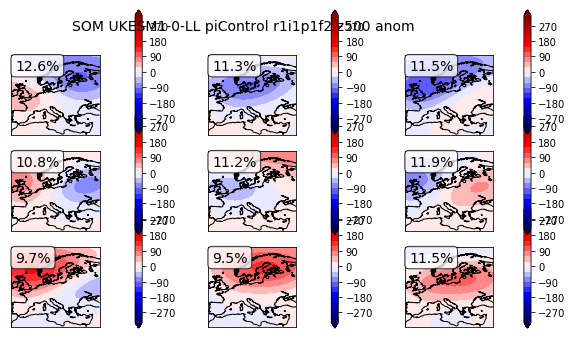

In [22]:

zg_str = "zg"
file_zg_tot = xarray.open_dataset(file_zg_str)
file_zg_tot_sel = file_zg_tot.sel(time = np.isin(file_zg_tot['time.season'], "JJA"))
lats_arr, lons_arr = [30,76], [-10,41]
#"fdr_bh", "sidak" and "k-FWER"
#all cover different variations on the mltiple hypothesis test applied in Horton et al 2015
mult_test_method = "fdr_bh"
suptitle = "SOM UKESM1-0-LL piControl r1i1p1f2 z500 anom"
g=1#9.80616
n_rows, n_columns= 3,3
savefig_SOM=f"/rds/general/user/cmt3718/home/plots/SOM/SOM_UKESM1-0-LL_r1i1p1f2_piControl_{n_rows}x{n_columns}_detrended_{domain}_xranom_{zg_str}_LTDM.png"
savefig_trends=f"/rds/general/user/cmt3718/home/plots/SOM/SOM_UKESM1-0-LL_r1i1p1f2_piControl_{n_rows}x{n_columns}_detrended_circtrends_{domain}_xranom_{zg_str}_LTDM.png"
nt_yr, nr_lat, nr_lon = file_zg_tot_sel[zg_str].shape
data_yr_reshaped = file_zg_tot_sel[zg_str].values.reshape(nt_yr, nr_lat*nr_lon)/g
SOM_data, som_yr = get_SOM_data(file_zg_tot_sel, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
            savefig_SOM, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #yrst=1979, yrend=2013
                data_yr_reshaped, JJA_days=92)



# freqs, gradients, SOM_data = get_SOM_data(file_zg_tot, yrst, yrend, 
#                                               "JJA", "Europe", "pca", "gaussian",
#                                               0.5, 100, 1, 1, "linear",  0.1, 0.01, "linear", 
#                                               savefig_SOM, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g,
#                                           zg_str, colormap_str, suptitle, mult_test_method, JJA_days=92)


In [33]:

sin_UK = xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/Sinuosity/Sin_JJA_cmip6_UKESM1-0-LL_r1i1p1f2_piControl_1960-2060_EUR.nc")['Sinuosity']

In [32]:
UKESM_files=sorted(glob.glob(f'/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/training_yrs/*blocked_clusters*'))
#combine the above files to create the cross-validated test aataset
SOMBI_arr = []
for file in UKESM_files:
    da=xr.open_dataset(file)['blocking']
    SOMBI_arr.append(da)
SOMBI = xr.concat(SOMBI_arr, dim="time")
SOMBI_JJA = SOMBI.sel(time = np.isin(SOMBI['time.season'], "JJA"))

In [31]:
GTD_str = "/rds/general/user/cmt3718/home/data/cmip6/GTD_UKESM1-0-LL/GTD_UKESM1-0-LL_piControl_1960-2060_JJAextd.nc"
#"/rds/general/project/nowack_graven/live/carl_som_index/data/GTD_UKESM1-0-LL_piControl_1960-2060_JJAextd.nc"


GTD = xr.open_dataset(GTD_str)['blocking']
GTD_JJA = GTD.sel(time=np.isin(GTD['time.season'], "JJA"))

lat_str, lon_str = "lat", "lon"

y_day = <xarray.DataArray 'Sinuosity' (time: 12)>
array([3.095947, 2.880463, 2.642153, 1.903463, 2.472228, 2.872899, 2.605166,
       2.635419, 2.973849, 3.388848, 3.583871, 3.299253])
Coordinates:
  * time     (time) object 2014-07-16 12:00:00 ... 2014-07-27 12:00:00


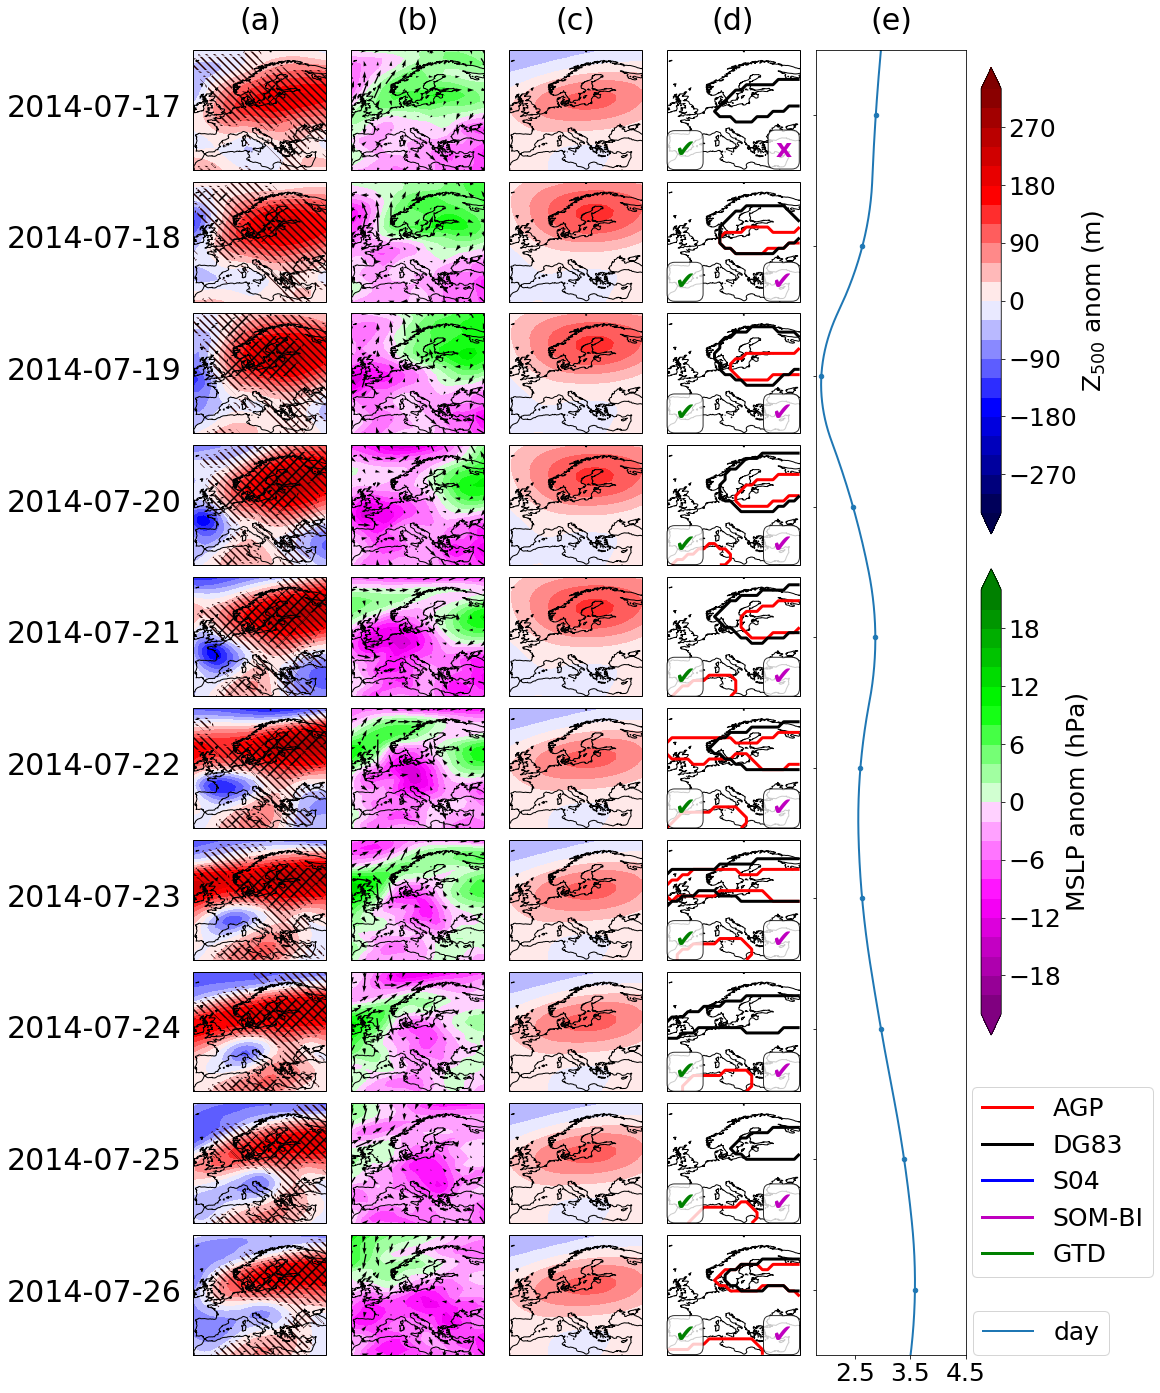

In [41]:

#for the 2003 HW
def plot_gph_temp_uv_SOM(day, days_plotting):
    """
    Plot the gph, temperature, u v and SOM maps
    define day_JJAextd and day_JJA as the index values for the days for the JJA and JJAextd periods (not consistent here with the selected variables)
    """

    ##fig, axs = plt.subplots(days_plotting, 4, sharey = True, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10,18))
    x, y = uwnd[lon_str], uwnd[lat_str]
    fig = plt.figure(constrained_layout=False, figsize=(14,24))
    day_orig=day#.copy()
    ##matplotlib.gridspec.GridSpec(nrows, ncols, figure=None, left=None, bottom=None, right=None, top=None, wspace=None, hspace=None, width_ratios=None, height_ratios=None)[source]
    spec = gridspec.GridSpec(ncols=5, nrows=days_plotting, figure=fig, width_ratios=[1,1,1,1,1], hspace=0.1,wspace=0.05)  # left = 0, right = 2, bottom = 0, top = 8,
    ax5 = fig.add_subplot(spec[:, 4])
    for i in range(days_plotting):
        day = day + 1
        ax1 = fig.add_subplot(spec[i, 0], projection=ccrs.PlateCarree())
        ax2 = fig.add_subplot(spec[i, 1], projection=ccrs.PlateCarree())
        ax3 = fig.add_subplot(spec[i, 2], projection=ccrs.PlateCarree())
        ax4 = fig.add_subplot(spec[i, 3], projection=ccrs.PlateCarree())         
        #axs = [ax1, ax2, ax3, ax4]# = axs[i]#, axs[i,1], axs[i,2]
        u, v = uwnd[day,:,:].values, vwnd[day,:,:].values
        
        # Create a cube containing the wind speed
        windspeed = (u ** 2 + v ** 2) ** 0.5
        for ax in [ax1, ax2, ax3, ax4]:#axs[i]:
            ax.coastlines("50m")
            ax.set_extent([-10, 40, 30, 75], ccrs.PlateCarree())
        t2m_arr = np.asarray(t2m_file[day]-273.15).ravel()
        #print(f"day zg = {zg_file['time.day'][day]}")
        #print(f"day SOMBI_JJA = {SOMBI_JJA['time.day'][day]}")
        #print(f"day GTD_JJA = {GTD_JJA['time.day'][day]}")              
        #print(f"day t2m = {t2m_file['time.day'][day]}")
        #print(f"day uwnd = {uwnd['time.day'][day]}")
        #print(f"day vwnd = {vwnd['time.day'][day]}")
        #print(f"day pv_file = {pv_file['time.day'][day]}")  
        #print(f"AGP = {AGP.}")
        
        date_str = f"{int(zg_file['time.year'][day])}-{int(zg_file['time.month'][day]):02d}-{int(zg_file['time.day'][day]):02d}"
        
        t2m_levels = np.linspace(min(t2m_arr), max(t2m_arr), 10)
        t2m_90pctl_day = t2m_file[day] > t2m_90pctl
        #t2m_95pctl_day = t2m_file[day] > t2m_95pctl 
        t2m_99pctl_day = t2m_file[day] > t2m_99pctl   

        levels = np.arange(5.2,6.2,0.1)
        levels = np.arange(-0.5,0.6,0.1)

        cs_zg = ax1.contourf(lon,lat,zg_file[day],  np.arange(vmin, vmax+step, step), latlon=True, cmap=plt.get_cmap(colormap_str),
                          extend='both')
        cs_pv = ax2.contourf(pv_file['lon'],pv_file['lat'],pv_file[day]/100, np.arange(vmin_pv, vmax_pv+step_pv, step_pv),
                         latlon=True, cmap=plt.get_cmap(newcmp),
                         extend='both')
        
        lw = 3
        llons, llats = np.meshgrid(AGP[lon_str].values, AGP[lat_str].values)
        c_S04 = ax4.contour(llons, llats, AGP[day], levels=[0,1], linewidths = lw, colors = "r", alpha=1)
        c_DG83 = ax4.contour(llons, llats, DG83[day], levels=[0,1], linewidths = lw, colors = "k", alpha=1)
        # Plot the wind speed as a contour plot
        llons, llats = np.meshgrid(x, y)
        ax2.quiver(x, y, u, v, pivot='middle', regrid_shape=10, color = "k", width=0.01)# headlength=10)# headwidth=1, scale = 10, headlength=4)
        plt.rcParams.update({'hatch.color': (0.15,0,0)})    
        bslash = r'\a'[0]
        hatch_str_90pctl=(bslash+bslash+bslash)
        hatch_str_99pctl=r"//"#"/"*4
        plt.rcParams['hatch.linewidth'] = 1.5
        if t2m_90pctl_day.sum() > 0:
            ax1.contourf(t2m_95pctl[lon_str], t2m_95pctl[lat_str], t2m_90pctl_day, 3, hatches=['', f"{hatch_str_90pctl}"],  alpha=0)
            plt.rcParams.update({'hatch.color': (0,0,0)})
        if t2m_99pctl_day.sum() > 0:
            ax1.contourf(t2m_99pctl[lon_str], t2m_99pctl[lat_str], t2m_99pctl_day, 3, hatches=['', f"{hatch_str_99pctl}"],  alpha=0)
            plt.rcParams.update({'hatch.color': (0.15,0,0)})
            plt.rcParams.update({'hatch.color': (0,0,0)})      
        #identify and mark if the SOMBI identifies the day as blocked or not
        SOMBI_lab = ["✔" if bool(SOMBI_JJA[day]) else "x"][0]#✔
        fs_caption = 25
        fs_text = 30
        fs_title = fs_text
        pad_title = 20
        fs_vertalign = "top"
        props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
        ax_text_loc = (-80, 50)
        if "x" in SOMBI_lab:
            SOMBI_lab_loc = (0.82, 0.27)
        else:
            SOMBI_lab_loc = (0.785, 0.265)
        fs_vertalign = "top"
        props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
        ax4.text(SOMBI_lab_loc[0], SOMBI_lab_loc[1], SOMBI_lab, transform=ax.transAxes, 
                 fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props, color = "m", weight="bold")
        
        GTD_lab = ["✔" if bool(GTD_JJA[day]) else "x"][0]
        if "x" in GTD_lab:
            GTD_lab_loc = (0.06, 0.265)
        else:
            GTD_lab_loc = (0.06, 0.265)
        GTD_col = "g"
        fs_vertalign = "top"
        props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
        ax4.text(GTD_lab_loc[0], GTD_lab_loc[1], GTD_lab, transform=ax.transAxes, 
                 fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props, color = GTD_col, weight="bold")
        
        
        #additionally make a separate plot showing the SOM pattern
        row_idx, col_idx = np.where(np.array(SOM_data)[:,:,day] == 1)[0][0], np.where(np.array(SOM_data)[:,:,day] == 1)[1][0]
        #flipped here so that the reshaping outputs the SOM node plot correctly
        SOM_map = (som_yr.codebook[row_idx,col_idx,:].reshape(len(lat),len(lon)))
        llons, llats = np.meshgrid(lon, lat)
        cs_SOM=ax3.contourf(llons, llats, SOM_map, np.arange(vmin, vmax+step, step), cmap=plt.get_cmap(colormap_str))
        ax1.text(ax_text_loc[0], ax_text_loc[1], date_str, fontsize=fs_text)
        if i == 0: #add the labels at the top
            ax1.set_title("(a)", fontsize=fs_title, pad = pad_title)
            ax2.set_title("(b)", fontsize=fs_title, pad = pad_title)
            ax3.set_title("(c)", fontsize=fs_title, pad = pad_title)
            ax4.set_title("(d)", fontsize=fs_title, pad = pad_title)
            ax5.set_title("(e)", fontsize=fs_title, pad = pad_title)
        if i == days_plotting-1:
            
            lw_BI_caption = 3
            fs_BI_caption = 25
            AGPleg = mlines.Line2D([], [], color='r', lw=lw_BI_caption,
                                      markersize=15, label='AGP')
            DG83leg = mlines.Line2D([], [], color='k', lw=lw_BI_caption,
                                      markersize=15, label='DG83')
            S04leg = mlines.Line2D([], [], color='b', lw=lw_BI_caption,
                                      markersize=15, label='S04')
            SOMBIleg = mlines.Line2D([], [], color='m', lw=lw_BI_caption,
                                      markersize=15, label='SOM-BI')
            GTDleg = mlines.Line2D([], [], color=GTD_col, lw=lw_BI_caption,
                                      markersize=15, label='GTD')                 
            ax4.legend(handles=[AGPleg, DG83leg, S04leg, SOMBIleg, GTDleg], loc=(2.3,0.65), fontsize=fs_BI_caption)
            height_cb, width_cb = 0.27, 0.02
            y_pos_cb_zg, y_pos_cb_pv = 0.6, 0.31
            x_pos_cb = 0.915
            fs_cb = 25
            fs_ticks_cb = 25
            cax_zg = fig.add_axes([x_pos_cb, y_pos_cb_zg, width_cb, height_cb])
            cax_pv = fig.add_axes([x_pos_cb, y_pos_cb_pv, width_cb, height_cb])     
            cb_zg = fig.colorbar(cs_zg, cax=cax_zg, ax=ax1, orientation="vertical")
            cb_zg.set_label(r"Z$_{500}$ anom (m)", fontsize = fs_cb)     
            cb_pv = fig.colorbar(cs_pv, cax=cax_pv, ax=ax2, orientation="vertical")
            cb_pv.set_label("MSLP anom (hPa)", fontsize = fs_cb)
            cb_pv.ax.tick_params(labelsize=fs_ticks_cb)  # set your label size here
            cb_zg.ax.tick_params(labelsize=fs_ticks_cb)                 
            
            
#             lw_BI_caption = 3
#             fs_BI_caption = 12
#             AGPleg = mlines.Line2D([], [], color='r', lw=lw_BI_caption,
#                                       markersize=15, label='AGP')
#             DG83leg = mlines.Line2D([], [], color='k', lw=lw_BI_caption,
#                                       markersize=15, label='DG83')
#             SOMBIleg = mlines.Line2D([], [], color='m', lw=lw_BI_caption,
#                                       markersize=15, label='SOM-BI')
#             GTDleg = mlines.Line2D([], [], color=GTD_col, lw=lw_BI_caption,
#                                       markersize=15, label='GTD')                 
#             ax4.legend(handles=[AGPleg, DG83leg, SOMBIleg, GTDleg], bbox_to_anchor=(1,-0.05), fontsize=fs_BI_caption)
#             width_cb, height_cb = 0.33, 0.017
#             y_pos_cb = 0.1
#             fs_cb = 15
#             fs_ticks_cb = 14
#             cax_zg = fig.add_axes([-0.04, y_pos_cb, width_cb, height_cb])
#             cax_pv = fig.add_axes([0.30, y_pos_cb, width_cb, height_cb])     
#             cb_zg = fig.colorbar(cs_zg, cax=cax_zg, ax=ax1, orientation="horizontal")
#             cb_zg.set_label(r"Z$_{500}$ anom (m)", fontsize = fs_cb)     
#             cb_pv = fig.colorbar(cs_pv, cax=cax_pv, ax=ax2, orientation="horizontal")
#             cb_pv.set_label("MSLP anom (hPa)", fontsize = fs_cb)
#             cb_pv.ax.tick_params(labelsize=fs_ticks_cb)  # set your label size here
#             cb_zg.ax.tick_params(labelsize=fs_ticks_cb)     
            #cb_pv.tick_params(axis='x', labelsize=fs_ticks_cb)
            #cb_zg.tick_params(axis='x', labelsize=fs_ticks_cb)
                 
    lw_sin = 2
    markersize_sin = 20
    fs_sin_lab = 25
    marker_3hr = "x"
    marker_day = "o"
    #plot the sinuosity at a daily scale
    x_day = np.arange(day-days_plotting+1-1,day+1+1)
    y_day = sin_UK[day-days_plotting+1-1:day+1+1]
    print(f"y_day = {y_day}")
    y_day = np.flip(y_day)
    x_day_new = np.linspace(min(x_day), max(x_day),500)
    f = interp1d(x_day, y_day, kind='quadratic')
    y_day_smooth = f(x_day_new)
    
    ax5.scatter(y_day, x_day, s=markersize_sin, marker = marker_day)
    ax5.plot(y_day_smooth, x_day_new, lw=lw_sin, label = "day")

    ax5.set_ylim(x_day[0]+0.5, x_day[-1]-0.5)
    ax5.set_yticks(np.arange(day_orig+1, day_orig+days_plotting+1, 1))    
    ax5.set_yticklabels(np.arange(x_day[0]+0.5, x_day[-1]-0.5, 1))# - removes the tick labels   
    ax5.axes.yaxis.set_ticklabels([])
    #ax5.set_yticks(x_day)
    
    #ax5.set_xlim(1,3.75)
    ax5.set_xticks(np.arange(2.5,5.5,1))
    ax5.tick_params(axis='x', labelsize=fs_sin_lab)
                 
    #sin caption             
    ax5.legend(loc=(1.05,0.0), fontsize=fs_BI_caption)
                 
    #print(f"x_day = {x_day}")
    #print(f"y_day = {y_day}")    
    fig.savefig(f"/rds/general/user/cmt3718/home/plots/weather_maps/CaseStudy/{date_str}UKESM.png", bbox_inches = "tight", dpi = 300)
    fig.savefig(f"/rds/general/user/cmt3718/home/plots/weather_maps/CaseStudy/{date_str}UKESM.pdf", bbox_inches = "tight", dpi = 300)    
    plt.show()
   # ✔ 
st_date_JJA = 4905#4905+16#6346
#st_date_JJA = 6347
#8400#4905
#4909 is the largest heatwave in the dataset, 4905 looks good but wasn't labelled as blocked in GTD
                 
days_plotting = 10
 
plot_gph_temp_uv_SOM(st_date_JJA, days_plotting) 


In [164]:
#DG83[90*70+39:90*70+39+17].sum(axis=1).sum(axis=1)
AGP[90*54+39:90*54+39+8+17].sum(axis=1).sum(axis=1)

<xarray.DataArray 'TM90_clusters' (time: 25)>
array([  0,   0,   0,   0,   0,   0,   0,   0,  39,  44,  64,  82, 132, 130,
        39,  34,  91, 114,  96,  37,  36,  38,  35,  25,   0])
Coordinates:
  * time     (time) object 2014-07-10 12:00:00 ... 2014-08-04 12:00:00

In [145]:
SOMBI_JJA[90*70+39+16:90*70+39+31]#.sum(axis=1).sum(axis=1)
#AGP[90*70+39+16:90*70+39+31].sum(axis=1).sum(axis=1)

<xarray.DataArray 'blocking' (time: 15)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * time     (time) object 2030-07-26 12:00:00 ... 2030-08-10 12:00:00

In [144]:
SOMBI_JJA[90*70+39:90*70+39+17]
#[4860+10:4860+46]

<xarray.DataArray 'blocking' (time: 17)>
array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])
Coordinates:
  * time     (time) object 2030-07-10 12:00:00 ... 2030-07-26 12:00:00

In [289]:
AGP_occ, DG83_occ = AGP.sum(axis=1).sum(axis=1)>0, DG83.sum(axis=1).sum(axis=1)>0


In [298]:
sum_blo=GTD_JJA.values[:9000]+SOMBI_JJA.values+(AGP_occ.values[:9000]+1-1)+(DG83_occ.values[:9000]+1-1)

(2030, 2031)

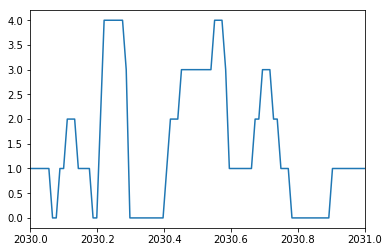

In [319]:
plt.plot(np.linspace(1960,2059,9000), sum_blo)
plt.xlim(2030,2031)

In [62]:
t2m_99pctl_tot = t2m_file > t2m_99pctl
t2m_90pctl_tot = t2m_file > t2m_90pctl

In [63]:
t2m_99pctl_sum=t2m_99pctl_tot.sum(axis=1).sum(axis=1)
t2m_90pctl_sum=t2m_90pctl_tot.sum(axis=1).sum(axis=1)

In [48]:
#find the region with the highest number of grid cells at the 99th heat percentile

np.where(t2m_99pctl_sum == t2m_99pctl_sum.max())
#plt.plot(range(9090), t2m_99pctl_sum)

(array([4909]),)

In [64]:
np.where(t2m_90pctl_sum == t2m_90pctl_sum.max())

(array([4908]),)

In [57]:
t2m_99pctl_sum.max()

<xarray.DataArray 'tas' ()>
array(147)
Coordinates:
    height    float64 ...
    quantile  float64 0.99

(2013, 2015)

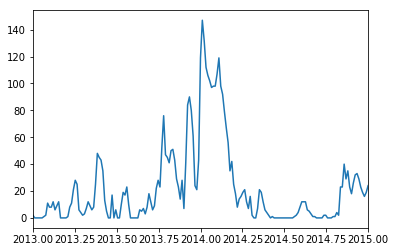

In [56]:
plt.plot(np.linspace(1960,2060,9090), t2m_99pctl_sum)
plt.xlim(2013,2015)

In [70]:
t2m_99pctl_bool=t2m_99pctl_tot.sum(axis=1).sum(axis=1)>0

In [71]:
t2m_99pctl_bool

<xarray.DataArray 'tas' (time: 9090)>
array([ True,  True,  True, ...,  True,  True,  True])
Coordinates:
    height    float64 ...
  * time      (time) object 1960-06-01 12:00:00 ... 2060-08-30 12:00:00
    quantile  float64 0.99